In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.measure import find_contours
from skimage.morphology import skeletonize
from skimage.filters import gaussian
from skimage.draw import polygon
import cv2


image_folder = 'E:/PW2/DRIONS-DB/images'
expert1_folder = 'E:/PW2/DRIONS-DB/experts_anotation'
expert2_folder = 'E:/PW2/DRIONS-DB/experts_anotation'
resized_folder = 'E:/PW2/DRIONS-DB/resized_images2'
populated_folder = 'E:/PW2/DRIONS-DB/populated_images2'
mask_folder = 'E:/PW2/DRIONS-DB/u_net_masks2'


os.makedirs(resized_folder, exist_ok=True)
os.makedirs(populated_folder, exist_ok=True)
os.makedirs(mask_folder, exist_ok=True)


def load_coordinates(file_path):
    try:
        coords = np.genfromtxt(file_path, delimiter=',')
        if coords.ndim == 1:
            coords = coords.reshape(-1, 2)
        if coords.shape[1] != 2:
            raise ValueError(f"Invalid format in file: {file_path}")
        return coords
    except Exception as e:
        print(f"Error loading coordinates from {file_path}: {e}")
        return None


def coords_to_mask(coords, shape):
    mask = np.zeros(shape, dtype=np.uint8)
    rr, cc = polygon(coords[:, 1], coords[:, 0], shape)
    mask[rr, cc] = 1
    return mask


image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))])

for image_file in image_files:
    image_number = os.path.splitext(image_file)[0][-3:]
    expert1_file = os.path.join(expert1_folder, f'anotExpert1_{image_number}.txt')
    expert2_file = os.path.join(expert2_folder, f'anotExpert2_{image_number}.txt')

    image_path = os.path.join(image_folder, image_file)
    image = Image.open(image_path).convert('RGB')

    resized_image = image.resize((512, 512))
    resized_output_path = os.path.join(resized_folder, f'resized_{image_number}.png')
    resized_image.save(resized_output_path)

    expert1_coords = load_coordinates(expert1_file)
    expert2_coords = load_coordinates(expert2_file)

    if expert1_coords is None or expert2_coords is None:
        print(f"Skipping image {image_number} due to invalid annotation files.")
        continue

    original_shape = image.size[::-1]
    expert1_mask = coords_to_mask(expert1_coords, original_shape)
    expert2_mask = coords_to_mask(expert2_coords, original_shape)
    intersection_mask = expert1_mask & expert2_mask

    skeleton = skeletonize(intersection_mask > 0)

    skeleton_output_path = os.path.join(mask_folder, f'skeleton_{image_number}.png')
    Image.fromarray((skeleton * 255).astype(np.uint8)).save(skeleton_output_path)

    print(f'Saved Skeletonized Vessel Image: {skeleton_output_path}')

    vessel_convergence = cv2.distanceTransform((intersection_mask * 255).astype(np.uint8), cv2.DIST_L2, 3)
    vessel_convergence = gaussian(vessel_convergence, sigma=3)

    vessel_convergence_output_path = os.path.join(mask_folder, f'convergence_{image_number}.png')
    Image.fromarray((vessel_convergence * 255 / vessel_convergence.max()).astype(np.uint8)).save(vessel_convergence_output_path)

    print(f'Saved Vessel Convergence Image: {vessel_convergence_output_path}')

    input_size = (256, 256)
    image_np = np.array(resized_image)
    green_channel = image_np[:, :, 1]

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(green_channel)

    resized_enhanced = cv2.resize(enhanced_image, input_size) / 255.0
    resized_enhanced = np.expand_dims(resized_enhanced, axis=[0, -1])

    resized_mask = cv2.resize(intersection_mask, input_size, interpolation=cv2.INTER_NEAREST)
    resized_mask = np.expand_dims(resized_mask, axis=[0, -1])

    np.save(os.path.join(resized_folder, f'train_image_{image_number}.npy'), resized_enhanced)
    np.save(os.path.join(mask_folder, f'train_mask_{image_number}.npy'), resized_mask)

    print(f'Saved training data: {image_number}')

print("Preprocessing completed successfully!")


Saved Skeletonized Vessel Image: E:/PW2/DRIONS-DB/u_net_masks2\skeleton_001.png
Saved Vessel Convergence Image: E:/PW2/DRIONS-DB/u_net_masks2\convergence_001.png
Saved training data: 001
Saved Skeletonized Vessel Image: E:/PW2/DRIONS-DB/u_net_masks2\skeleton_002.png
Saved Vessel Convergence Image: E:/PW2/DRIONS-DB/u_net_masks2\convergence_002.png
Saved training data: 002
Saved Skeletonized Vessel Image: E:/PW2/DRIONS-DB/u_net_masks2\skeleton_003.png
Saved Vessel Convergence Image: E:/PW2/DRIONS-DB/u_net_masks2\convergence_003.png
Saved training data: 003
Saved Skeletonized Vessel Image: E:/PW2/DRIONS-DB/u_net_masks2\skeleton_004.png
Saved Vessel Convergence Image: E:/PW2/DRIONS-DB/u_net_masks2\convergence_004.png
Saved training data: 004
Saved Skeletonized Vessel Image: E:/PW2/DRIONS-DB/u_net_masks2\skeleton_005.png
Saved Vessel Convergence Image: E:/PW2/DRIONS-DB/u_net_masks2\convergence_005.png
Saved training data: 005
Saved Skeletonized Vessel Image: E:/PW2/DRIONS-DB/u_net_masks2\sk

In [ ]:
from PIL import Image
import numpy as np
import os
import cv2

# Paths
superpixel_folder = 'E:/PW2/DRIONS-DB/superpixel_maps'
mask_folder = 'E:/PW2/DRIONS-DB/u_net_masks2'
resized_folder = 'E:/PW2/DRIONS-DB/resized_images2'
final_u_net_folder = 'E:/PW2/DRIONS-DB/u_net_input'

# Ensure output directory exists
os.makedirs(final_u_net_folder, exist_ok=True)

# Get list of images
image_files = sorted([f for f in os.listdir(resized_folder) if f.endswith('.png')])

for image_file in image_files:
    image_number = os.path.splitext(image_file)[0].split('_')[-1]

    # Load the resized image (green channel)
    image_path = os.path.join(resized_folder, image_file)
    image = np.array(Image.open(image_path).convert('RGB'))
    green_channel = image[:, :, 1] / 255.0  # Normalize to [0,1]

    # Load the superpixel map
    superpixel_path = os.path.join(superpixel_folder, f'superpixel_resized_{image_number}.png')
    superpixel_map = np.array(Image.open(superpixel_path).convert('L')) / 255.0

    # Load the skeletonized vessel map
    skeleton_path = os.path.join(mask_folder, f'skeleton_{image_number}.png')
    skeleton_map = np.array(Image.open(skeleton_path).convert('L')) / 255.0

    # Load the vessel convergence map
    convergence_path = os.path.join(mask_folder, f'convergence_{image_number}.png')
    convergence_map = np.array(Image.open(convergence_path).convert('L')) / 255.0

    # Resize all to match U-Net input size
    input_size = (256, 256)
    green_channel = cv2.resize(green_channel, input_size)
    superpixel_map = cv2.resize(superpixel_map, input_size)
    skeleton_map = cv2.resize(skeleton_map, input_size)
    convergence_map = cv2.resize(convergence_map, input_size)

    # Stack all maps to create a multi-channel U-Net input
    u_net_input = np.stack([green_channel, superpixel_map, skeleton_map, convergence_map], axis=-1)

    # Save the final U-Net input array
    np.save(os.path.join(final_u_net_folder, f'u_net_input_{image_number}.npy'), u_net_input)

    print(f'Saved multi-channel U-Net input: {image_number}')

print("U-Net input generation completed successfully!")


Saved multi-channel U-Net input: 001
Saved multi-channel U-Net input: 002
Saved multi-channel U-Net input: 003
Saved multi-channel U-Net input: 004
Saved multi-channel U-Net input: 005
Saved multi-channel U-Net input: 006
Saved multi-channel U-Net input: 007
Saved multi-channel U-Net input: 008
Saved multi-channel U-Net input: 009
Saved multi-channel U-Net input: 010
Saved multi-channel U-Net input: 011
Saved multi-channel U-Net input: 012
Saved multi-channel U-Net input: 013
Saved multi-channel U-Net input: 014
Saved multi-channel U-Net input: 015
Saved multi-channel U-Net input: 016
Saved multi-channel U-Net input: 017
Saved multi-channel U-Net input: 018
Saved multi-channel U-Net input: 019
Saved multi-channel U-Net input: 020
Saved multi-channel U-Net input: 021
Saved multi-channel U-Net input: 022
Saved multi-channel U-Net input: 023
Saved multi-channel U-Net input: 024
Saved multi-channel U-Net input: 025
Saved multi-channel U-Net input: 026
Saved multi-channel U-Net input: 027
S

In [ ]:
import os
from sklearn.model_selection import train_test_split

image_folder = 'E:/PW2/DRIONS-DB/u_net_input'
mask_folder = 'E:/PW2/DRIONS-DB/u_net_masks'

x_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.npy')])
y_files = sorted([f for f in os.listdir(mask_folder) if f.endswith('.png')])
if not x_files:
    raise ValueError("No input image files found in the specified folder!")
if not y_files:
    raise ValueError("No mask files found in the specified folder!")

valid_pairs = []
for x in x_files:
    image_number = os.path.splitext(x)[0].split('_')[-1]
    mask_name = f"mask_{image_number}.png"

    mask_path = os.path.join(mask_folder, mask_name)

    if os.path.exists(mask_path):
        valid_pairs.append((x, mask_name))
    else:
        print(f"⚠️ Missing mask file: {mask_path}")

if not valid_pairs:
    raise ValueError("No valid (image, mask) pairs found! Check file paths and naming consistency.")

x_files, y_files = zip(*valid_pairs)

X_train_files, X_val_files, Y_train_files, Y_val_files = train_test_split(
    x_files, y_files, test_size=0.2, random_state=42
)

print(f"✅ Training samples: {len(X_train_files)}")
print(f"✅ Validation samples: {len(X_val_files)}")

with open("train_files.txt", "w") as f:
    f.write("\n".join(X_train_files))

with open("val_files.txt", "w") as f:
    f.write("\n".join(X_val_files))

print("📌 Data split successfully!")


✅ Training samples: 88
✅ Validation samples: 22
📌 Data split successfully!


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

input_folder = 'E:/PW2/DRIONS-DB/u_net_input'
mask_folder = 'E:/PW2/DRIONS-DB/u_net_masks'
x_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.npy')])
y_files = sorted([f for f in os.listdir(mask_folder) if f.endswith('.png')])

valid_pairs = [(x, y) for x, y in zip(x_files, y_files) if os.path.exists(os.path.join(mask_folder, y))]

if not valid_pairs:
    raise ValueError("⚠️ No valid image-mask pairs found! Check filenames.")

x_files, y_files = zip(*valid_pairs)

print(f"✅ Found {len(x_files)} valid pairs.")


✅ Found 110 valid pairs.


In [ ]:
X_train_files, X_val_files, Y_train_files, Y_val_files = train_test_split(
    x_files, y_files, test_size=0.2, random_state=42
)

print(f"✅ Training samples: {len(X_train_files)}, Validation samples: {len(X_val_files)}")


✅ Training samples: 88, Validation samples: 22


In [ ]:
import cv2
from tensorflow.keras.utils import to_categorical

def load_data(x_file_list, y_file_list, input_folder, mask_folder, img_size=(256, 256)):
    X_data, Y_data = [], []

    for x_file, y_file in zip(x_file_list, y_file_list):
        x_path = os.path.join(input_folder, x_file)
        x_image = np.load(x_path)
        y_path = os.path.join(mask_folder, y_file)
        y_mask = cv2.imread(y_path, cv2.IMREAD_GRAYSCALE)
        y_mask = cv2.resize(y_mask, img_size)
        y_mask = y_mask / 255.0
        y_mask = np.expand_dims(y_mask, axis=-1)
        X_data.append(x_image)
        Y_data.append(y_mask)

    return np.array(X_data), np.array(Y_data)

X_train, Y_train = load_data(X_train_files, Y_train_files, input_folder, mask_folder)
X_val, Y_val = load_data(X_val_files, Y_val_files, input_folder, mask_folder)

print(f"✅ X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"✅ X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")


✅ X_train shape: (88, 256, 256, 4), Y_train shape: (88, 256, 256, 1)
✅ X_val shape: (22, 256, 256, 4), Y_val shape: (22, 256, 256, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.models import Model

def unet_model(input_size=(256, 256, 4)):
    inputs = Input(input_size)

    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

unet = unet_model()
unet.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 4)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         2368      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
history = unet.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=8,
    verbose=1
)


Epoch 1/20
11/11 [==============================] - 208s 19s/step - loss: 4.7822 - accuracy: 0.9697 - val_loss: 0.4852 - val_accuracy: 0.9692
Epoch 2/20
11/11 [==============================] - 194s 18s/step - loss: 0.2831 - accuracy: 0.9710 - val_loss: 0.1559 - val_accuracy: 0.9692
Epoch 3/20
11/11 [==============================] - 190s 17s/step - loss: 0.1085 - accuracy: 0.9710 - val_loss: 0.0521 - val_accuracy: 0.9692
Epoch 4/20
11/11 [==============================] - 190s 17s/step - loss: 0.0334 - accuracy: 0.9738 - val_loss: 0.0224 - val_accuracy: 0.9927
Epoch 5/20
11/11 [==============================] - 189s 17s/step - loss: 0.0094 - accuracy: 0.9966 - val_loss: 0.0050 - val_accuracy: 0.9976
Epoch 6/20
11/11 [==============================] - 189s 17s/step - loss: 0.0033 - accuracy: 0.9979 - val_loss: 0.0026 - val_accuracy: 0.9980
Epoch 7/20
11/11 [==============================] - 189s 17s/step - loss: 0.0024 - accuracy: 0.9982 - val_loss: 0.0022 - val_accuracy: 0.9982
Epoch 

In [ ]:
unet.save("E:/PW2/DRIONS-DB/u_net_segmentation_model.h5")
print("✅ Model saved successfully!")


C:\Users\Venkat\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Model saved successfully!


In [ ]:
import os
import numpy as np
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

input_folder = 'E:/PW2/DRIONS-DB/u_net_input'
mask_folder = 'E:/PW2/DRIONS-DB/u_net_masks'
def load_test_data(x_files, y_files, input_folder, mask_folder, img_size=(256, 256)):
    X_test, Y_test = [], []

    for x_file, y_file in zip(x_files, y_files):
        x_path = os.path.join(input_folder, x_file)
        x_image = np.load(x_path)

        y_path = os.path.join(mask_folder, y_file)
        y_mask = cv2.imread(y_path, cv2.IMREAD_GRAYSCALE)
        y_mask = cv2.resize(y_mask, img_size) / 255.0
        y_mask = np.expand_dims(y_mask, axis=-1)

        X_test.append(x_image)
        Y_test.append(y_mask)

    return np.array(X_test), np.array(Y_test)

X_test, Y_test = load_test_data(x_files, y_files, input_folder, mask_folder)

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

def evaluate_model(model, X_test, Y_test, threshold=0.5):

    Y_pred = model.predict(X_test)
    Y_pred = (Y_pred > threshold).astype(np.uint8)

    Y_test_flat = (Y_test > 0.5).astype(np.uint8).flatten()
    Y_pred_flat = Y_pred.flatten()

    accuracy = accuracy_score(Y_test_flat, Y_pred_flat)
    precision = precision_score(Y_test_flat, Y_pred_flat)
    recall = recall_score(Y_test_flat, Y_pred_flat)
    f1 = f1_score(Y_test_flat, Y_pred_flat)
    dice = dice_coefficient(Y_test_flat, Y_pred_flat)
    iou = jaccard_score(Y_test_flat, Y_pred_flat)

    print(f"✅ Accuracy: {accuracy:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1-score: {f1:.4f}")
    print(f"✅ Dice Score: {dice:.4f}")
    print(f"✅ IoU (Jaccard Index): {iou:.4f}")

    return accuracy, precision, recall, f1, dice, iou

evaluate_model(unet, X_test, Y_test)


4/4 [==============================] - 120s 29s/step
✅ Accuracy: 0.9994
✅ Precision: 0.9955
✅ Recall: 0.9846
✅ F1-score: 0.9901
✅ Dice Score: 0.9901
✅ IoU (Jaccard Index): 0.9803


(0.999427656693892,
 0.9955436590486997,
 0.9846195164763489,
 0.9900514546673289,
 0.9900514546673529,
 0.9802989065558898)

✅ Training samples: 88
✅ Validation samples: 22
📌 Data split successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


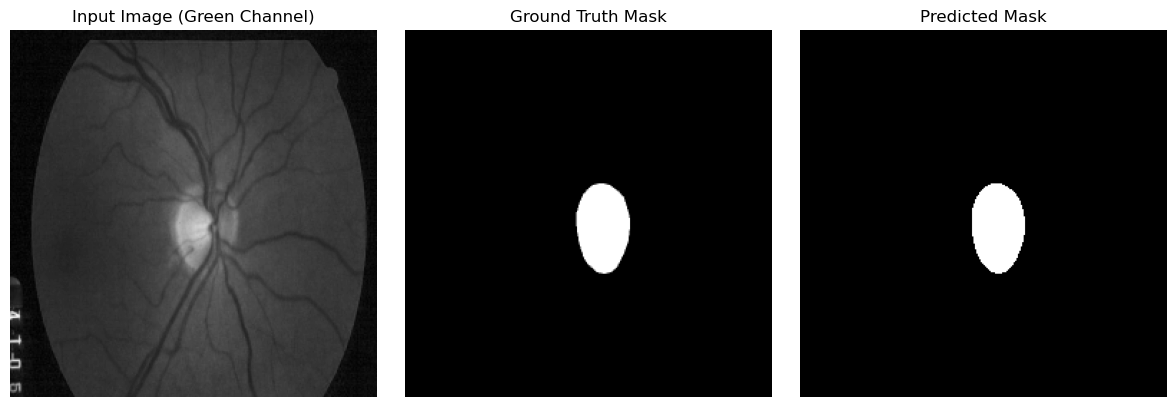

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
image_folder = 'E:/PW2/DRIONS-DB/u_net_input'
mask_folder = 'E:/PW2/DRIONS-DB/u_net_masks'
x_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.npy')])
y_files = sorted([f for f in os.listdir(mask_folder) if f.endswith('.png')])
if not x_files:
    raise ValueError("No input image files found in the specified folder!")
if not y_files:
    raise ValueError("No mask files found in the specified folder!")
valid_pairs = []
for x in x_files:
    image_number = os.path.splitext(x)[0].split('_')[-1]
    mask_name = f"mask_{image_number}.png"
    mask_path = os.path.join(mask_folder, mask_name)

    if os.path.exists(mask_path):
        valid_pairs.append((x, mask_name))
    else:
        print(f"⚠️ Missing mask file: {mask_path}")
if not valid_pairs:
    raise ValueError("No valid (image, mask) pairs found! Check file paths and naming consistency.")
x_files, y_files = zip(*valid_pairs)
X_train_files, X_val_files, Y_train_files, Y_val_files = train_test_split(
    x_files, y_files, test_size=0.2, random_state=42
)
print(f"✅ Training samples: {len(X_train_files)}")
print(f"✅ Validation samples: {len(X_val_files)}")
with open("train_files.txt", "w") as f:
    f.write("\n".join(X_train_files))

with open("val_files.txt", "w") as f:
    f.write("\n".join(X_val_files))

print("📌 Data split successfully!")
input_folder = 'E:/PW2/DRIONS-DB/u_net_input'
mask_folder = 'E:/PW2/DRIONS-DB/u_net_masks'
def load_test_data(x_files, y_files, input_folder, mask_folder, img_size=(256, 256)):
    X_test, Y_test = [], []

    for x_file, y_file in zip(x_files, y_files):
        x_path = os.path.join(input_folder, x_file)
        x_image = np.load(x_path)
        y_path = os.path.join(mask_folder, y_file)
        y_mask = cv2.imread(y_path, cv2.IMREAD_GRAYSCALE)
        y_mask = cv2.resize(y_mask, img_size) / 255.0
        y_mask = np.expand_dims(y_mask, axis=-1)
        X_test.append(x_image)
        Y_test.append(y_mask)

    return np.array(X_test), np.array(Y_test)

X_test, Y_test = load_test_data(x_files, y_files, input_folder, mask_folder)

def visualize_predictions(model, X_data, Y_data, index=0, threshold=0.5):
    pred_mask = model.predict(np.expand_dims(X_data[index], axis=0))[0]
    pred_mask_bin = (pred_mask > threshold).astype(np.uint8)
    input_image = X_data[index][:, :, 0]
    ground_truth = Y_data[index][:, :, 0]
    prediction = pred_mask_bin[:, :, 0]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(input_image, cmap='gray')
    plt.title("Input Image (Green Channel)")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(prediction, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
model_path = "E:/PW2/DRIONS-DB/u_net_segmentation_model.h5"
unet_model_loaded = tf.keras.models.load_model(model_path)
visualize_predictions(unet_model_loaded, X_test, Y_test, index=4)
